In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from hyperopt import hp, fmin, rand
import collections

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv("DC-Madrid.csv")
df.head()

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,Historic Anacostia,Private room,55,2,74,2020-11-30,0.60,2,341,"Washington, D.C."
1,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Private room,99,2,31,2016-09-22,0.25,3,173,"Washington, D.C."
2,"Kalorama Heights, Adams Morgan, Lanier Heights",Entire home/apt,74,3,95,2020-03-05,0.69,2,177,"Washington, D.C."
3,"Kalorama Heights, Adams Morgan, Lanier Heights",Private room,42,2,112,2019-10-30,0.82,2,0,"Washington, D.C."
4,"Dupont Circle, Connecticut Avenue/K Street",Entire home/apt,185,2,154,2020-10-05,1.18,2,1,"Washington, D.C."


In [3]:
df = df.drop(columns=['neighbourhood'])

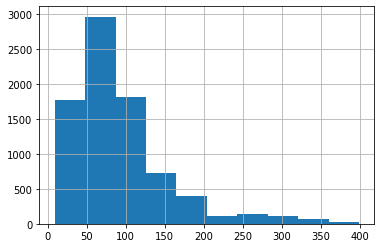

In [4]:
df.price.hist()

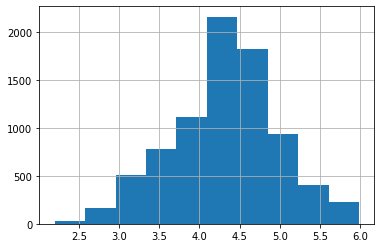

In [17]:
np.log(df.price).hist()

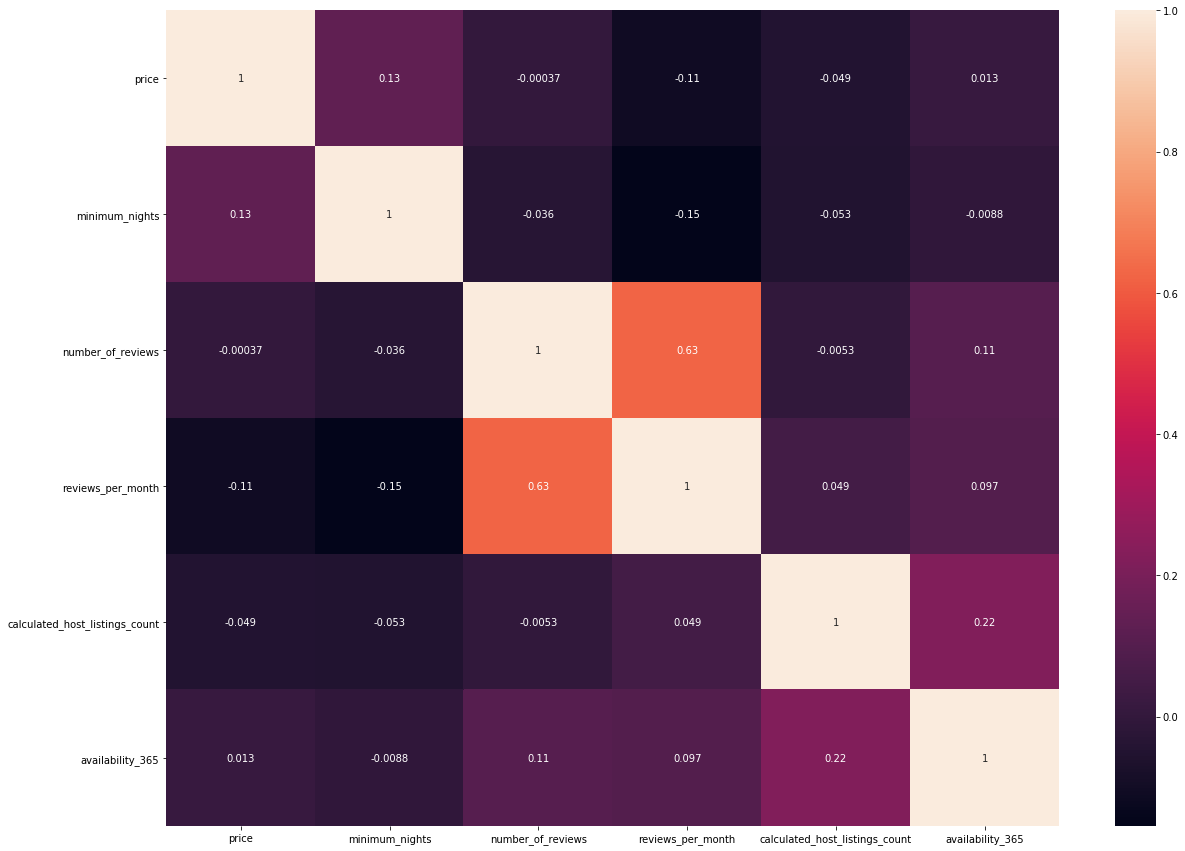

In [5]:
corrmat = df[df._get_numeric_data().columns].corr().round(7)
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, annot=True)
plt.show()

In [6]:
df.price=np.log(df.price)

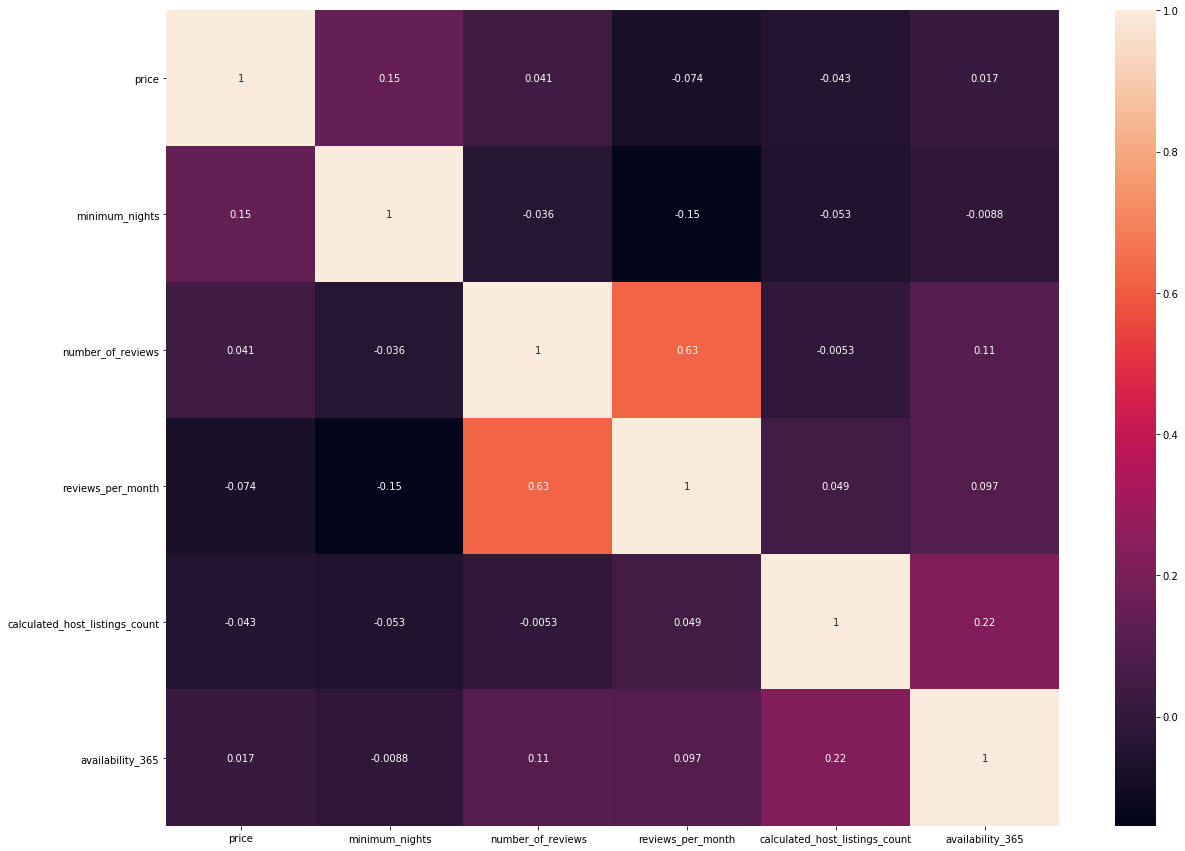

In [7]:
corrmat = df[df._get_numeric_data().columns].corr().round(7)
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, annot=True)
plt.show()

In [8]:
def encoding_char(df):
    char_var = list(set(df.columns) - set(df._get_numeric_data().columns))
    for col_names in char_var:
        f = pd.factorize(df[col_names])
        df[col_names] = pd.factorize(df[col_names])[0]
    return(df)

df = encoding_char(df)
df.head()

,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,0,4.007333,2,74,0,0.60,2,341,0
1,0,4.595120,2,31,1,0.25,3,173,0
2,1,4.304065,3,95,2,0.69,2,177,0
3,0,3.737670,2,112,3,0.82,2,0,0
4,1,5.220356,2,154,4,1.18,2,1,0


In [9]:
train, test = train_test_split(df, test_size=0.2, random_state=0)
X_train = train.drop('price', axis=1)
X_test = test.drop('price', axis=1)
y_train = train.price
y_test = test.price

In [10]:
def metrics(X_train, X_test, y_train, y_test, y_pred, model):
    MSE = [mean_squared_error(np.exp(y_train), np.exp(model.predict(X_train))), mean_squared_error(np.exp(y_test), np.exp(y_pred))]
    RMSE = [np.sqrt(mean_squared_error(np.exp(y_train), np.exp(model.predict(X_train)))),np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))]
    R2 = [model.score(X_train, y_train), model.score(X_test, y_test)]
    results = {'MSE': MSE, 'RMSE': RMSE, 'R2':R2}
    return pd.DataFrame(results, index=['Train', 'Test'])

def visualising(X_train, X_test, y_train, y_test, y_pred, model):
    ### Training set ### 
    plt.scatter(X_train[['reviews_per_month']], np.exp(y_train), color = 'red')
    plt.plot(X_train[['reviews_per_month']], np.exp(model.predict(X_train)), 'bo')
    plt.title('Price vs Reviews per month (Training set)')
    plt.xlabel('Reviews per month')
    plt.ylabel('Price')
    plt.show()
    
    ### Test set ### 
    plt.scatter(X_test[['reviews_per_month']], np.exp(y_test), color = 'red')
    plt.plot(X_test[['reviews_per_month']], np.exp(y_pred), 'bo')
    plt.title('Price vs Reviews per month (Test set)')
    plt.xlabel('Reviews per month')
    plt.ylabel('Price')
    plt.show()


In [11]:
mr = LinearRegression().fit(X_train, y_train)
mr.coef_, mr.intercept_

(array([ 4.81120295e-01,  2.90339030e-02,  2.09576385e-04, -4.91102715e-06,
        -2.11586001e-02, -2.15079643e-03,  3.73384484e-04, -5.73065828e-01]),
 4.1752747131831836)

In [12]:
mr_y_pred = mr.predict(X_test)
metrics(X_train, X_test, y_train, y_test, mr_y_pred, mr).round(2)

,MSE,RMSE,R2
Train,3031.20,55.06,0.39
Test,3143.82,56.07,0.43


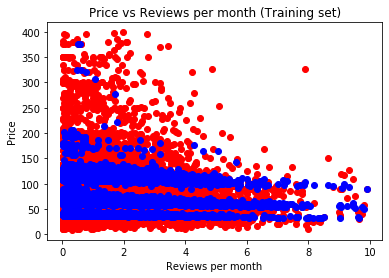

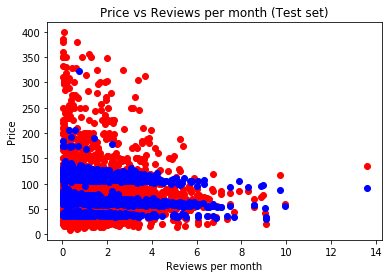

In [13]:
visualising(X_train, X_test, y_train, y_test, mr_y_pred, mr)

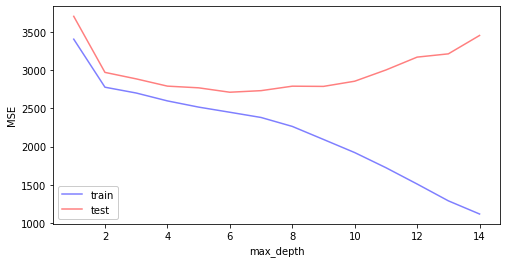

In [15]:
def max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = DecisionTreeRegressor(max_depth = i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(rf.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(rf.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

    
max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [16]:
dt = DecisionTreeRegressor(max_depth = 6, random_state=10).fit(X_train, y_train)
dt_y_pred = dt.predict(X_test)
metrics(X_train, X_test, y_train, y_test, dt_y_pred, dt).round(2)

,MSE,RMSE,R2
Train,2449.85,49.50,0.57
Test,2711.79,52.07,0.55


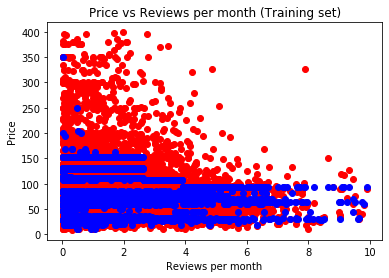

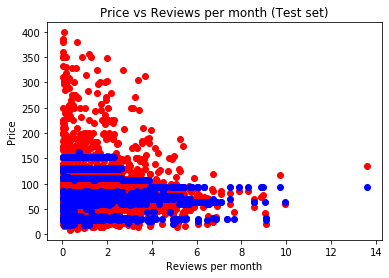

In [17]:
visualising(X_train, X_test, y_train, y_test, dt_y_pred, dt)

Text(0.5, 1.0, 'Decision Tree. Feature Importance')

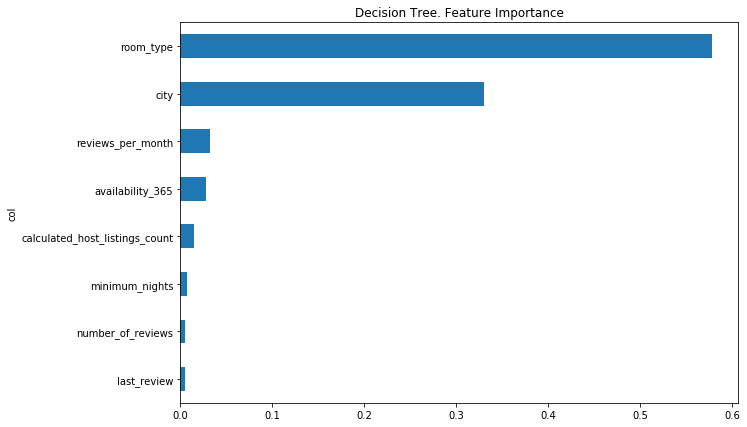

In [18]:
dt_imp = pd.DataFrame({'imp': dt.feature_importances_, 'col': X_train.columns})
dt_imp = dt_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
dt_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('Decision Tree. Feature Importance')

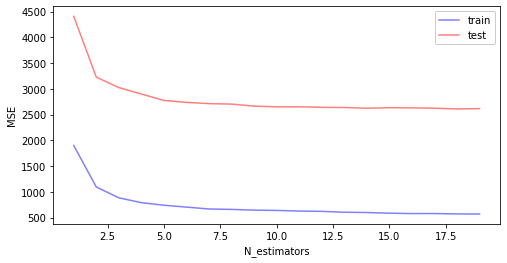

In [19]:
def rf_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestRegressor(n_estimators=i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(rf.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(rf.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("N_estimators")
    ax.legend(framealpha=1, frameon=True);

    
rf_best_n_estimator(X_train, X_test, y_train, y_test, list(range(1,20)))

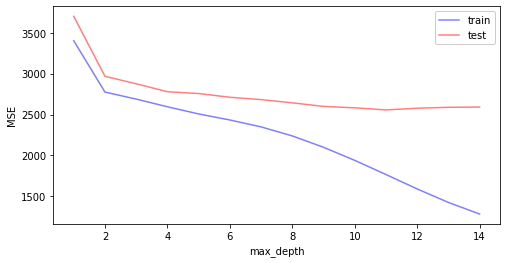

In [20]:
def rf_max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestRegressor(n_estimators=10, max_depth =i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(rf.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(rf.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

    
rf_max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [21]:
rf = RandomForestRegressor(n_estimators = 5, max_depth = 7, random_state = 10).fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
metrics(X_train, X_test, y_train, y_test, rf_y_pred, rf).round(2)

,MSE,RMSE,R2
Train,2367.70,48.66,0.61
Test,2703.33,51.99,0.56


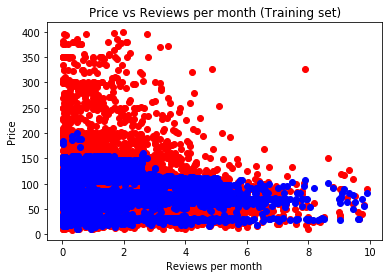

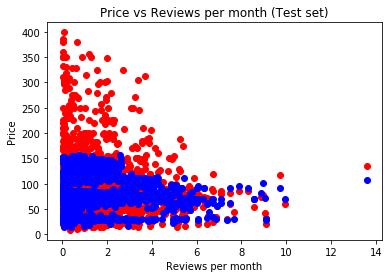

In [22]:
visualising(X_train, X_test, y_train, y_test, rf_y_pred, rf)

Text(0.5, 1.0, 'Random Forest. Feature Importance')

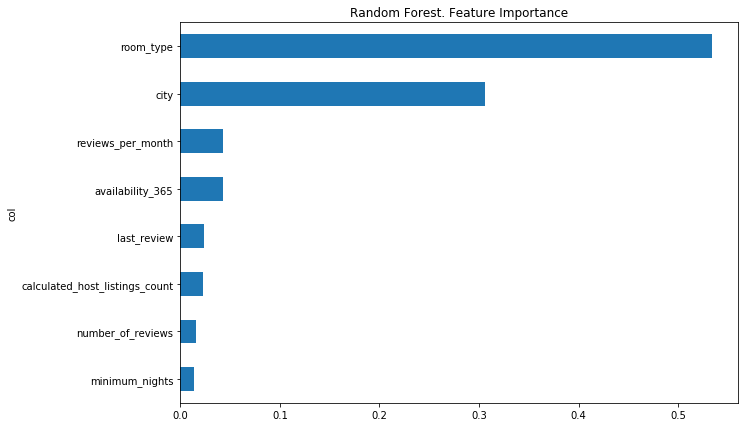

In [23]:
rf_imp = pd.DataFrame({'imp': rf.feature_importances_, 'col': X_train.columns})
rf_imp = rf_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
rf_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('Random Forest. Feature Importance')

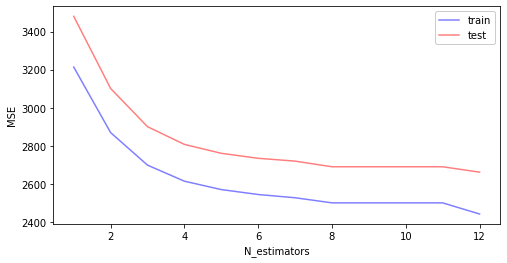

In [24]:
def catboost_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=i, random_state=10, eval_metric='RMSE', loss_function='RMSE').fit(X_train, y_train,
                                                                                                                 eval_set=(X_test, y_test),
                                                                                                                  logging_level='Silent')
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(catboost.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(catboost.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("N_estimators")
    ax.legend(framealpha=1, frameon=True);

    
catboost_best_n_estimator(X_train, X_test, y_train, y_test, list(range(1,13)))



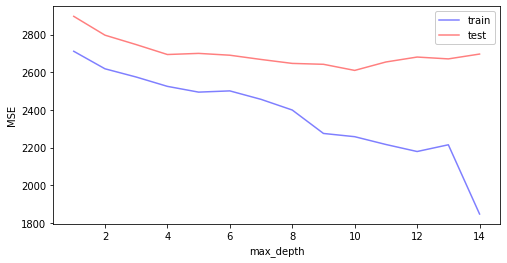

In [25]:
def catboost_max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=11, max_depth=i, random_state=10, eval_metric='RMSE', loss_function='RMSE').fit(X_train, y_train,
                                                                                                                 eval_set=(X_test, y_test),
                                                                                                                  logging_level='Silent')
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(catboost.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(catboost.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

    
catboost_max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [26]:
catboost = CatBoostRegressor(iterations=11, max_depth=8, random_state=10, eval_metric='RMSE', loss_function='RMSE').fit(X_train, y_train,
                                                                                                                 eval_set=(X_test, y_test),
                                                                                                                  logging_level='Silent')
cat_y_pred = catboost.predict(X_test)
metrics(X_train, X_test, y_train, y_test, cat_y_pred, catboost).round(2)

,MSE,RMSE,R2
Train,2399.16,48.98,0.59
Test,2646.75,51.45,0.57


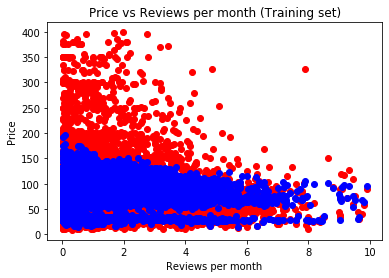

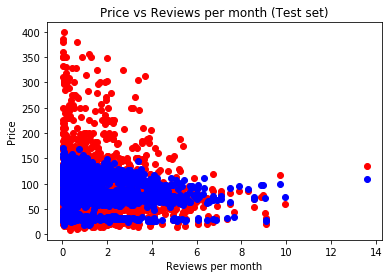

In [27]:
visualising(X_train, X_test, y_train, y_test, cat_y_pred, catboost)

Text(0.5, 1.0, 'Boosting. Feature Importance')

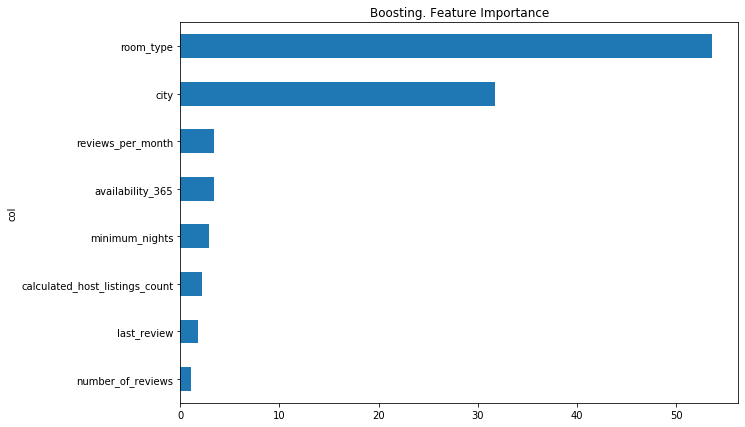

In [28]:
cb_imp = pd.DataFrame({'imp': catboost.get_feature_importance(), 'col': X_train.columns})
cb_imp = cb_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
cb_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('Boosting. Feature Importance')

In [33]:
Spaces = collections.OrderedDict([
    ('learning_rate', hp.loguniform('learning_rate', np.log(0.001), np.log(0.05))),
    ('num_leaves', hp.choice('num_leaves', range(10, 70, 5))),
    ('num_iterations', hp.choice('num_iterations', range(1, 30, 2))),
    ('min_data_in_leaf', hp.choice('min_data_in_leaf', range(10, 100, 1))),
    ('objective', hp.choice('objective', ['regression_l1', 'regression_l1', 'mse']))
])

In [ ]:
Ordere